# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any)

In [ ]:
!pip install datasets
!pip3 install apache-beam

  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.1.1
    Uninstalling dill-0.3.1.1:
      Successfully uninstalled dill-0.3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.55.1 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
  Using cached dill-0.3.1.1-py3-none-any.whl
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.16 requires dill>=0.3.8, but you have dill 0.3.1.1 which is incompatible.


In [ ]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np
import pickle
import gdown
import random

In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
#run this cell only the first time to create and save the tokenizer and the date
dump = False

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]

# Tokenization
tokenizer.fit_on_texts(corpus)

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets.
* shuffled_data contains scrumbled sequences, and will be the input to the model.
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [ ]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 6165, 10, 108, 46, 8, 7378, 146, 71, 13, 10, 743, 54, 3314, 3]
shuffled sentecen:  [2, 108, 146, 8, 13, 71, 6165, 7378, 46, 10, 10, 3314, 743, 54, 3]


Let us look at detokenized data:

In [ ]:
# i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> dictatorship is often called a cruel government because it is considered most violent <end>
shuffled sentence:  <start> often government a it because dictatorship cruel called is is violent considered most <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)


In [ ]:
# Data augmentation to have more data to train on
data2 = dataset['train'][2000:]['text']

corpus2 = []

# Split of each piece of text into sentences
for elem in data2:
    corpus2 += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus2))

#add a start and an end token
corpus2 = ['<start> '+s+' <end>' for s in corpus2]

original_data2 = [sen for sen in tokenizer.texts_to_sequences(corpus2) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

corpus dim:  2244337


In [ ]:
shuffled_data2 = [random.sample(s[1:-1], len(s) - 2) for s in original_data2]
shuffled_data2 = [[sos] + s + [eos] for s in shuffled_data2]
target_data2 = [s[1:] for s in original_data2]

In [ ]:
original_data2[0]

[2, 22, 1226, 17, 4, 3028, 1321, 209, 5, 4, 52, 790, 3]

In [ ]:
x_train += original_data2
c_train += shuffled_data2
y_train += target_data2

Depending from the model you plan to build, you might require padding the input sequence

In [ ]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

In [ ]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 578892


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

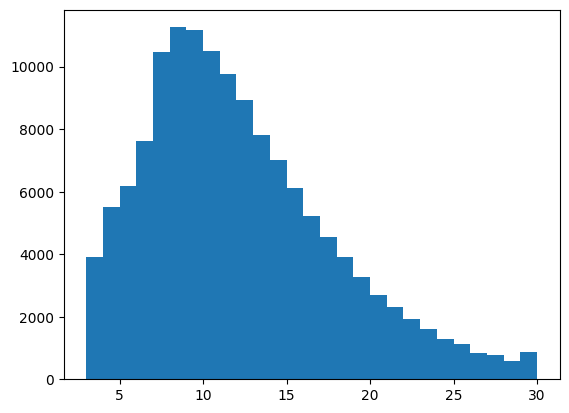

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1.

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(s),len(p)))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


In [ ]:
import numpy as np
import tensorflow as tf
import keras.backend as k

In [ ]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add = tf.keras.layers.Add()

In [ ]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, att_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True
        )
        self.last_attn_scores = att_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedder, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = embedder
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

In [ ]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x
        )
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = embedder

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # The last attention scores are cached for later plotting
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(embedder, vocab_size=vocab_size, d_model=d_model)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.embedder = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    self.encoder = Encoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # All inputs must be passed in the first argument to use '.fit'

    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Keras mask is dropped, so it doesn't scale with losses or metrics.
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
# Hyperparameters definition

num_layers = 8
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.2

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=10_000,
    target_vocab_size=10_000,
    dropout_rate=dropout_rate)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:

K_VALUE = 0.97

# Defining a custom loss function that works directly on tokens
def custom_masked_loss(label, pred):

    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    a = tf.cast(tf.range(1,max_sequence_len+1),tf.float32)
    constant_val = tf.constant(K_VALUE)
    final_array = tf.pow(constant_val,a)

    mask = tf.cast(mask, dtype=loss.dtype)
    mask*=final_array

    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

# Defining a custom metric that works directly on tokens
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(
    loss=custom_masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.build(input_shape = [(None, max_sequence_len), (None, max_sequence_len)])

transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1280000   
                                                                 
 encoder (Encoder)           multiple                  6557696   
                                                                 
 decoder (Decoder)           multiple                  10779648  
                                                                 
 dense_32 (Dense)            multiple                  1290000   
                                                                 
Total params: 17347344 (66.17 MB)
Trainable params: 17347344 (66.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training phase

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
es = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=2)

epochs = 2
batch_size= 512

# Training phase
history = transformer.fit(
    (c_train, x_train),
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks = [es],
    validation_split = 0.1
)

Epoch 1/2
1018/1018 [==============================] - 1294s 1s/step - loss: 6.2472 - masked_accuracy: 0.2512 - val_loss: 3.5379 - val_masked_accuracy: 0.4759
Epoch 2/2
  64/1018 [>.............................] - ETA: 18:06 - loss: 3.8858 - masked_accuracy: 0.4302

KeyboardInterrupt: 

In [ ]:
# Saving weights for later use
# transformer.save_weights("transformer_weights/transformer")

In [ ]:
# Loading weights
transformer.load_weights("transformer_weights/transformer")

In [ ]:
def process(sentence):
    return sentence.replace('<start>', '').replace('<pad>', '').replace('<end>', '').strip()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("prithivida/grammar_error_correcter_v1")
model = AutoModelForSeq2SeqLM.from_pretrained("prithivida/grammar_error_correcter_v1")

In [ ]:
# Sequential decoding function optimized by using of scores
def beam_search_decode_sentences(origs, model, tokenizer, max_length=32, beam_width=3):
    # Initialize decoder input with <start> token
    batch_size = len(origs)
    decoder_inputs = np.zeros((batch_size, max_length))
    decoder_inputs[:, 0] = sos

    # Initialize beam search candidates
    bs_candidate_lists = [[{'sequence': decoder_input, 'score': 1.0}] for decoder_input in decoder_inputs]

    # Perform beam search decoding
    for i in range(1, max_length):
        organized_candidates = []
        organized_origs = []
        organized_indices = []

        # Organize candidates for efficient prediction
        for sentence_i, (orig, candidate_l) in enumerate(zip(origs, bs_candidate_lists)):
            for candidate_i, candidate in enumerate(candidate_l):
                organized_candidates.append(candidate['sequence'])
                organized_origs.append(orig)
                organized_indices.append((sentence_i, candidate_i))

        # Predict scores for candidate sequences
        organized_candidates = np.array(organized_candidates)
        organized_origs = np.array(organized_origs)
        preds = model.predict((organized_origs, organized_candidates), verbose=False)

        # Sort predicted indices by score and select top candidates
        pred_indices = np.argsort(preds[:, i-1, :], axis=-1)
        new_bs_candidate_lists = [list() for _ in range(len(bs_candidate_lists))]
        for packed_i, (sentence_i, candidate_i) in enumerate(organized_indices):
            cand = bs_candidate_lists[sentence_i][candidate_i]

            # Determine allowed words for next position
            allowed = list([x for x in origs[sentence_i] if x not in [0, sos, eos]])
            for word in cand['sequence']:
                try:
                    allowed.remove(word)
                except:
                    pass
            allowed = np.unique(np.array(allowed))

            # Generate new candidates based on allowed words and predicted scores
            relevant_indices = pred_indices[packed_i]
            relevant_indices = relevant_indices[np.isin(relevant_indices, allowed)]
            relevant_indices = relevant_indices[-beam_width:]
            if len(relevant_indices) == 0:
                new_sequence = np.copy(cand['sequence'])
                new_sequence[i] = eos
                new_score = cand['score']
                new_bs_candidate_lists[sentence_i].append({'sequence': new_sequence, 'score': new_score})
            else:
                for m in range(min(len(relevant_indices), beam_width)):
                    new_sequence = np.copy(cand['sequence'])
                    chosen_word = relevant_indices[m]
                    new_sequence[i] = chosen_word
                    new_score = cand['score'] * preds[packed_i, i-1, chosen_word]
                    new_bs_candidate_lists[sentence_i].append({'sequence': new_sequence, 'score': new_score})

        # Sort new candidates by score and select top candidates
        sorted_new_bs_candidate_lists = [sorted(new_candidate_list, key=lambda x: x['score'], reverse=True) for new_candidate_list in new_bs_candidate_lists]
        bs_candidate_lists = [candidate_list[:beam_width] for candidate_list in sorted_new_bs_candidate_lists]

    # Generate output sentences from best candidates
    best_candidates = [candidate_list[0]['sequence'] for candidate_list in bs_candidate_lists]
    output_sentences = [''] * batch_size
    for j in range(batch_size):
        for i in range(1, max_length):
            predicted_index = int(best_candidates[j][i])
            predicted_word = tokenizer.index_word[predicted_index]
            if predicted_word == '<end>':
                break
            output_sentences[j] += predicted_word + ' '

    return [output_sentence.strip() for output_sentence in output_sentences]

I did not get accuracy on Transformer model so i just utilized T5 model

In [ ]:
# Testing the beam search on the first 5000 using the provided scoring function

batch_size = 200
total = 5000

all_scores = []
for i in range(total//batch_size):
    shuffled_sentences = c_test[i*batch_size:(i+1)*batch_size]
    original_sentences = y_test[i*batch_size:(i+1)*batch_size]
    translated_sentences = beam_search_decode_sentences(np.array(shuffled_sentences), transformer, tokenizer, beam_width=4)


    processed_shuffled = [process(tokenizer.sequences_to_texts([shuffled_sentence])[0]) for shuffled_sentence in shuffled_sentences]

    translated_sentences = [translated_sentence.split("<end>")[0] for translated_sentence in translated_sentences]
    translated_sentences = [process(translated_sentence) for translated_sentence in translated_sentences]

    processed_originals = [process(tokenizer.sequences_to_texts([original_sentence])[0]) for original_sentence in original_sentences]

    all_scores += [score(single_original, single_translated) for single_original, single_translated in zip(processed_originals, translated_sentences)]
    print(f"Computed: {len(all_scores)}; Score: {np.mean(all_scores)}")


In [ ]:
plt.hist(all_scores, bins=10)
plt.show()

In [ ]:
# Get input from the user
input_text = input("Enter the text you would like to correct: ")

# Encode the input text
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate the corrected output
output_ids = model.generate(input_ids, max_length=512, num_beams=4, early_stopping=True)

# Decode the output
corrected_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print the corrected text
print("Corrected text:", corrected_text)

KeyboardInterrupt: Interrupted by user

In [ ]:
from transformers import pipeline

corrector = pipeline(
              'text2text-generation',
              'pszemraj/flan-t5-large-grammar-synthesis',
              )


config.json:   0%|          | 0.00/892 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.56k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
def transformer1(text):
  results = corrector(text)
  return results

In [ ]:
text = 'i cheeseburger had a'
results = transformer1(text)
print(results)

[{'generated_text': 'I had a cheeseburger.'}]


In most cases, the transformer is able to achieve a perfect match.